In [1]:
%%capture
!pip install pandas
!pip install numpy
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install seaborn
!pip install unidecode
!pip install -U imbalanced-learn
!pip3 install pickle5

In [2]:
import tensorflow as tf
import pandas as pd
import warnings
import unidecode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle5 as pickle
import random
import os
import re
import time
import nltk
nltk.download('stopwords')
sns.set_style('darkgrid')

from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Reshape, Dense, Dropout, Input, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, confusion_matrix

sw = set(stopwords.words('english'))
os.environ['PYTHONHASHSEED']=str(23)
tf.random.set_seed(23)
random.seed(23)
warnings.filterwarnings('ignore')
np.random.seed(23)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing

In [3]:
def remove_username(text):
  text = re.sub(r'\@[^\s]+', ' ', text)
  return text

def remove_newline(text):
  text = text.replace('\n', ' ')
  return text

def only_letters(text):
  text = re.sub(r'[^a-záâàãéêèẽíìîĩóòõôúùũû\s]+', ' ', text)
  return text

def remove_link(text):
  text = re.sub(r'www\.?[^\s]+', ' ', text)
  return text

def remove_hyperlink(text):
  text = re.sub(r'\<.?\>', ' ', text)
  return text

def remove_accent(text):
  text = unidecode.unidecode(text)
  return text

def adjustment_text(text):
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()
  return text

def remove_stopwords(text):
  text = [word for word in text.split() if word not in sw]
  text = ' '.join(text)
  return text

def remove_spam(text):
  text = re.sub(r'\&amp', ' ', text)
  text = re.sub(r'\&lt', ' ', text)
  text = re.sub(r'\&gt', ' ', text)
  text = re.sub(r'\#follow|\#followme|\#like|\#f4f|\#photooftheday', ' ', text)
  return text

def remove_slangs(text):
  text = re.sub(r' b4 ', ' before ', text)
  text = re.sub(r' 2b ', ' to be ', text)
  text = re.sub(r' 2morrow ', ' tomorrow ', text)
  text = re.sub(r' rn ', ' right now ', text)
  text = re.sub(r' brb ', ' be right back ', text)
  text = re.sub(r' mb ', ' my bad ', text)
  text = re.sub(r' luv ', ' love ', text)
  text = re.sub(r' b ', ' be ', text)
  text = re.sub(r' r ', ' are ', text)
  text = re.sub(r' u ', ' you ', text)
  text = re.sub(r' y ', ' why ', text)
  text = re.sub(r' ur ', ' your ', text)
  text = re.sub(r' hbd ', ' happy birthday ', text)
  text = re.sub(r' bday ', ' birthday ', text)
  text = re.sub(r' bihday ', ' birthday ', text)
  text = re.sub(r' omg ', ' oh my god ', text)
  text = re.sub(r' lol ', ' laughing out loud ', text)
  return text

def remove_abbreviations(text):
  text = re.sub(r" can\'t ", " can not ", text)
  text = re.sub(r" i\'m ", " i am ", text)
  text = re.sub(r" i\'ll ", " i will ", text)
  text = re.sub(r" i\'d ", " i would ", text)
  text = re.sub(r" i\'ve ", " i have ", text)
  text = re.sub(r" ain\'t ", " am not ", text)
  text = re.sub(r" haven\'t ", " have not ", text)
  text = re.sub(r" hasn\'t ", " has not ", text)
  text = re.sub(r" can\'t ", " can not ", text)
  text = re.sub(r" won\'t ", " will not ", text)
  text = re.sub(r" you\'re ", " you are ", text)
  text = re.sub(r" we\'re ", " we are ", text)
  text = re.sub(r" they\'re ", " they are ", text)
  text = re.sub(r" he\'s ", " he is ", text)
  text = re.sub(r" she\'s ", " she is ", text)
  text = re.sub(r" it\'s ", " it is ", text)
  text = re.sub(r" don\'t ", " do not ", text)
  text = re.sub(r" doesn\'t ", " does not ", text)
  text = re.sub(r" wouldn\'t ", " would not ", text)
  text = re.sub(r" couldn\'t ", " could not ", text)
  text = re.sub(r" shouldn\'t ", " should not ", text)
  return text

def remove_one_len_word(text):
  text = re.sub(r'\b[a-z]\b', ' ', text)
  return text

def preprocessing(data):
  data['cleaned_tweet'] = data['tweet'].apply(str)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x: x.lower())
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_newline)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_hyperlink)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_spam)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_link)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_username)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_abbreviations)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(only_letters)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_accent)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_slangs)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_stopwords)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_one_len_word)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(adjustment_text)
  return data

from google.colab import files
uploaded = files.upload()

!unzip Tokenizer

In [4]:
normal_data = pd.read_csv('Data/train.csv')
normal_data = normal_data.drop(columns=['id'])
normal_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [5]:
normal_data.shape

(31962, 2)

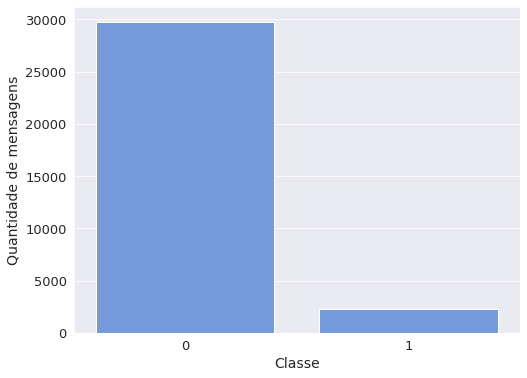

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(data=normal_data, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=14)
plt.xticks(fontsize=13)
plt.ylabel('Quantidade de mensagens', fontsize=14)
plt.yticks(fontsize=13)
plt.savefig('Images/data_unbalanced.png')

In [7]:
ros = RandomOverSampler(random_state=23, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(normal_data[['tweet']], normal_data['label'])
data_augmentation = pd.concat([X_resampled, y_resampled], axis=1)
data_augmentation.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


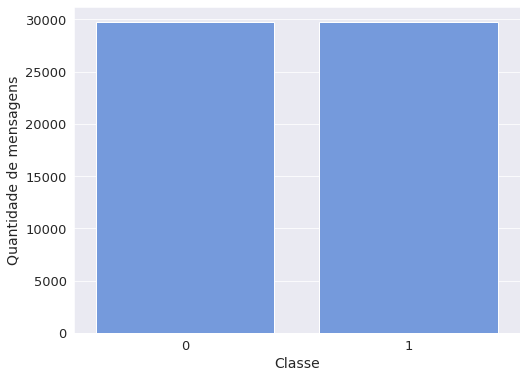

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data_augmentation, x='label', color='cornflowerblue')
plt.xlabel('Classe', fontsize=14)
plt.xticks(fontsize=13)
plt.ylabel('Quantidade de mensagens', fontsize=14)
plt.yticks(fontsize=13)
plt.savefig('Images/data_balanced.png')

In [9]:
data_augmentation.shape

(59440, 2)

In [10]:
preprocessed_data = normal_data.copy()
preprocessed_data = preprocessing(preprocessed_data)
preprocessed_data = preprocessed_data.replace('None', pd.NA)
preprocessed_data = preprocessed_data.dropna()
preprocessed_data = preprocessed_data.drop_duplicates()
preprocessed_data = preprocessed_data.drop(columns=['tweet'])
preprocessed_data = preprocessed_data.rename(columns={'cleaned_tweet': 'tweet'})
preprocessed_data.head()

,label,tweet
0,0,father dysfunctional selfish drags kids dysfun...
1,0,thanks lyft credit use cause offer wheelchair ...
2,0,birthday majesty
3,0,model love take time
4,0,factsguide society motivation


In [11]:
preprocessed_data.shape

(29530, 2)

In [12]:
ros = RandomOverSampler(random_state=23, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(preprocessed_data[['tweet']], preprocessed_data['label'])
data_preprocessing_augmentation = pd.concat([X_resampled, y_resampled], axis=1)
data_preprocessing_augmentation.head()

,tweet,label
0,father dysfunctional selfish drags kids dysfun...,0
1,thanks lyft credit use cause offer wheelchair ...,0
2,birthday majesty,0
3,model love take time,0
4,factsguide society motivation,0


In [13]:
data_preprocessing_augmentation.shape

(55034, 2)

## Tokenizer

with open(r"Tokenizer/tokenizer_rand.pickle", "rb") as output_file:
    tokenizer = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_rand_augmentantion.pickle", "rb") as output_file:
    tokenizer_augmentation = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_rand_preprocessing.pickle", "rb") as output_file:
    tokenizer_preprocessing = pickle.load(output_file)

with open(r"Tokenizer/tokenizer_rand_preprocessing_augmentantion.pickle", "rb") as output_file:
    tokenizer_preprocessing_augmentation = pickle.load(output_file)

In [14]:
all_messages = pd.concat([data_preprocessing_augmentation,
                          preprocessed_data,
                          normal_data,
                          data_augmentation], axis=0)

all_messages = all_messages.reset_index(drop=True)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_messages['tweet'].values)

In [15]:
with open('Tokenizer/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Word2vec

with open(r"Data/glove.pickle", "rb") as output_file:
    glove_embedding = pickle.load(output_file)

with open(r"Data/glove_preprocessing.pickle", "rb") as output_file:
    glove_preprocessing_embedding = pickle.load(output_file)

In [16]:
with open(r"Data/glove_total.pickle", "rb") as output_file:
    glove = pickle.load(output_file)

## Parameters

In [17]:
non_linearity_function = 'relu'
units = 50
first_dropout_rate = 0.25
last_dropout_rate = 0.5
epochs = 10
batch_size = 100
embedding_dim = 200
length_size = 30

## Tokenization + padding + splitting data step

In [18]:
def preprocessing_step(tokenizer, data, model, preprocessing, augmentation):
  
  # tokenizer = Tokenizer()
  # tokenizer.fit_on_texts(data['tweet'].values)

  data['tokenized'] = tokenizer.texts_to_sequences(data['tweet'].values)

  vocab_size = len(tokenizer.word_index) + 1

  X = pad_sequences(sequences = data['tokenized'],
                    maxlen = length_size,
                    padding = 'pre')

  y = data['label']

  X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15, random_state=23)

  return vocab_size, tokenizer, X_train, X_validation, y_train, y_validation

In [19]:
def generate_cm(model, X_validation, y_validation, prep, augmentation, nome):

  plt.figure(figsize = (10, 7))
  predicted_validation = (model.predict(X_validation) > 0.5).astype("int32")
  matrix = confusion_matrix(y_validation, predicted_validation, labels=[0, 1])
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, cmap="Blues", fmt='d', annot_kws={"size": 16})
  plt.xlabel('Classe prevista')
  plt.ylabel('Classe real')
  
  if prep:

    if augmentation:
      plt.savefig('Images/matriz_confusao_' + nome + '_preprocessing_augmentation.jpg')
    else:
      plt.savefig('Images/matriz_confusao_' + nome + '_preprocessing.jpg')

  else:

    if augmentation:
      plt.savefig('Images/matriz_confusao_' + nome + '_augmentation.jpg')
    else:
      plt.savefig('Images/matriz_confusao_' + nome + '.jpg')

## Predict

In [20]:
def predict(tokenizer, model, prep, augmentation, nome):

  test = pd.read_csv('Data/test.csv')

  if prep:
    test = preprocessing(test)
    test['tokenized'] = tokenizer.texts_to_sequences(test['cleaned_tweet'].values)
  else:
    test['tokenized'] = tokenizer.texts_to_sequences(test['tweet'].values)

  X_test = pad_sequences(sequences = test['tokenized'],
                         maxlen = length_size,
                         padding = 'pre')

  predicted = (model.predict(X_test) > 0.5).astype("int32")
  prediction = pd.DataFrame()
  prediction['id'] = test['id']
  prediction['label'] = predicted

  if prep:

    if augmentation:
      prediction.to_csv('Submission/' + nome + '_preprocessing_augmentation.csv', index=False)
    else:
      prediction.to_csv('Submission/' + nome + '_preprocessing.csv', index=False)

  else:

    if augmentation:
      prediction.to_csv('Submission/' + nome + '_augmentation.csv', index=False)
    else:
      prediction.to_csv('Submission/' + nome + '.csv', index=False)

## Save Models

In [21]:
def save_model(modelo, nome_modelo, preprocessing, augmentation):
  
  file_name = 'model_'

  if preprocessing:
    if augmentation:
      file_name = file_name + nome_modelo + '_preprocessing_augmentantion'
    else:
      file_name = file_name + nome_modelo + '_preprocessing'
  else:
    if augmentation:
      file_name = file_name + nome_modelo + '_augmentantion'
    else:
      file_name = file_name + nome_modelo

  modelo.save('Model/' + file_name + '.h5')

## Save embeddings

In [22]:
def save_embedding(modelo, tokenizer, nome_modelo, preprocessing, augmentation):
  embeddings = modelo.get_layer('embedding').get_weights()[0]
  w2v_my = {}

  for word, index in tokenizer.word_index.items():
      w2v_my[word] = embeddings[index]
  
  file_name = 'embedding_'

  if preprocessing:
    if augmentation:
      file_name = file_name + nome_modelo + '_preprocessing_augmentantion.pickle'
    else:
      file_name = file_name + nome_modelo + '_preprocessing.pickle'
  else:
    if augmentation:
      file_name = file_name + nome_modelo + '_augmentantion.pickle'
    else:
      file_name = file_name + nome_modelo + '.pickle'

  with open('Model/' + file_name + '.h5', 'wb') as handle:
    pickle.dump(w2v_my, handle, protocol=pickle.HIGHEST_PROTOCOL)

## LSTM normal

In [23]:
def lstm_normal(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, preprocessing, augmentation):

  model = Sequential()

  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=length_size,
                      name='embedding'))
  
  #droupout layer
  model.add(Dropout(rate = first_dropout_rate))

  #lstm layer
  model.add(LSTM(units = units))

  #dropout layer
  model.add(Dropout(rate = last_dropout_rate))

  #output layer
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model_random.summary()

  history_random = model.fit(X_train, 
                             y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(X_validation, y_validation))
  
  #save_embedding(model_random, tokenizer, 'LSTM', preprocessing, augmentation)

  save_model(model, 'LSTM', preprocessing, augmentation)

  predicted_validation = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(y_validation, predicted_validation, average='weighted')
  score = round(score, 4)

  generate_cm(model, X_validation, y_validation, preprocessing, augmentation, 'LSTM')
  
  predict(tokenizer, model, preprocessing, augmentation, 'LSTM')
  
  return model, history_random, score

## LSTM static

In [24]:
def lstm_static(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, preprocessing, augmentation):

  model = Sequential()

  #embedding layer
  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=length_size,
                      weights=[glove],
                      trainable=False,
                      name='embedding'))

  #droupout layer
  model.add(Dropout(rate = first_dropout_rate))

  #lstm layer
  model.add(LSTM(units = units))

  #dropout layer
  model.add(Dropout(rate = last_dropout_rate))

  #output layer
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model_random.summary()

  history_random = model.fit(X_train, 
                             y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(X_validation, y_validation))
  
  #save_embedding(model_random, tokenizer, 'LSTM-static', preprocessing, augmentation)

  save_model(model, 'LSTM-static', preprocessing, augmentation)

  predicted_validation = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(y_validation, predicted_validation, average='weighted')
  score = round(score, 4)

  generate_cm(model, X_validation, y_validation, preprocessing, augmentation, 'LSTM-static')

  predict(tokenizer, model, preprocessing, augmentation, 'LSTM-static')
  
  return model, history_random, score

## LSTM non-static

In [25]:
def lstm_non_static(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, preprocessing, augmentation):

  model = Sequential()

  #embedding layer
  model.add(Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=length_size,
                      weights=[glove],
                      trainable=True,
                      name='embedding'))
  
  #droupout layer
  model.add(Dropout(rate = first_dropout_rate))

  #lstm layer
  model.add(LSTM(units = units))

  #dropout layer
  model.add(Dropout(rate = last_dropout_rate))

  #output layer
  model.add(Dense(units=1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #model_random.summary()

  history_random = model.fit(X_train, 
                             y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(X_validation, y_validation))
  
  #save_embedding(model_random, tokenizer, 'LSTM-non_static', preprocessing, augmentation)

  save_model(model, 'LSTM-non_static', preprocessing, augmentation)

  predicted_validation = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(y_validation, predicted_validation, average='weighted')
  score = round(score, 4)

  generate_cm(model, X_validation, y_validation, preprocessing, augmentation, 'LSTM-non_static')

  predict(tokenizer, model, preprocessing, augmentation, 'LSTM-non_static')
  
  return model, history_random, score

## Main

Modelo: normal
Pré-processamento: False
Balanceamento: False

Epoch 1/10
272/272 [==============================] - 46s 162ms/step - loss: 0.1982 - accuracy: 0.9410 - val_loss: 0.1112 - val_accuracy: 0.9602
Epoch 2/10
272/272 [==============================] - 44s 162ms/step - loss: 0.0696 - accuracy: 0.9760 - val_loss: 0.1008 - val_accuracy: 0.9670
Epoch 3/10
272/272 [==============================] - 45s 164ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.1097 - val_accuracy: 0.9635
Epoch 4/10
272/272 [==============================] - 44s 162ms/step - loss: 0.0147 - accuracy: 0.9958 - val_loss: 0.1186 - val_accuracy: 0.9664
Epoch 5/10
272/272 [==============================] - 44s 162ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.1727 - val_accuracy: 0.9466
Epoch 6/10
272/272 [==============================] - 44s 161ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.1650 - val_accuracy: 0.9627
Epoch 7/10
272/272 [==============================] - 45s 165ms/step

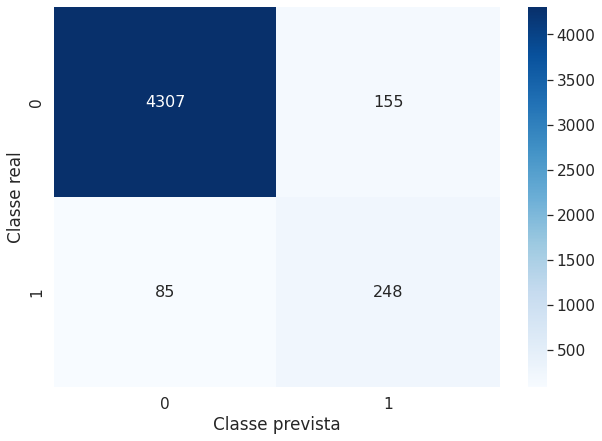

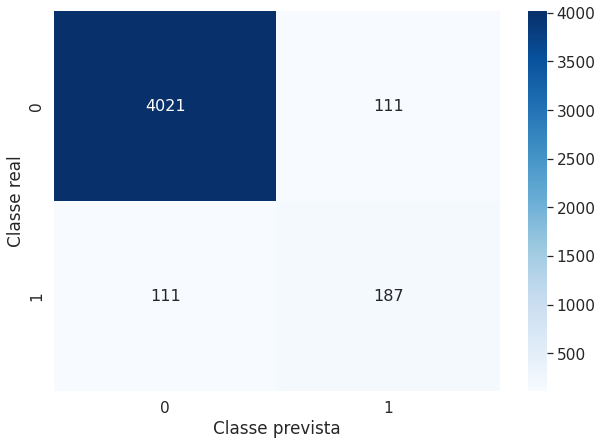

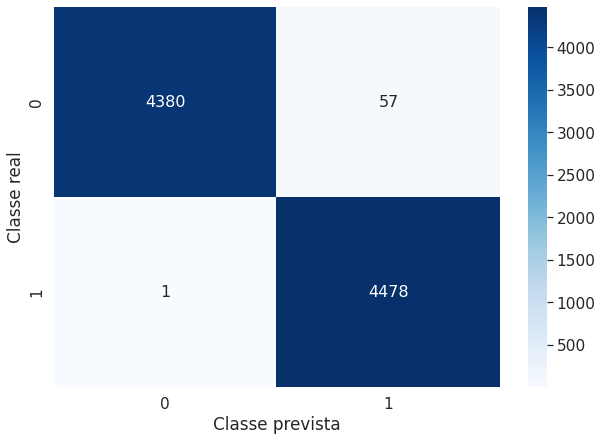

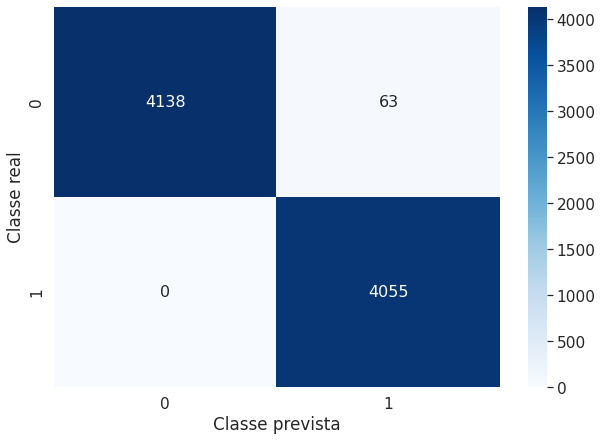

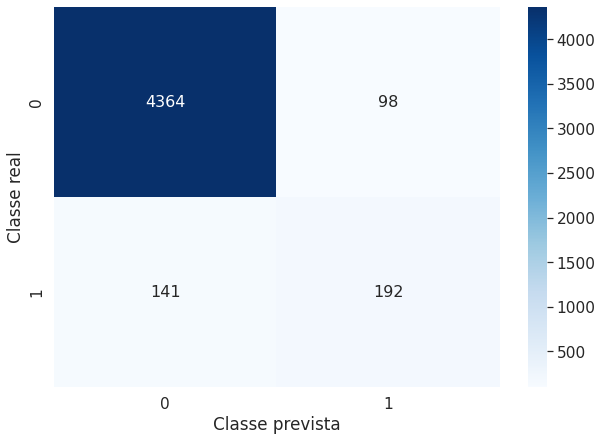

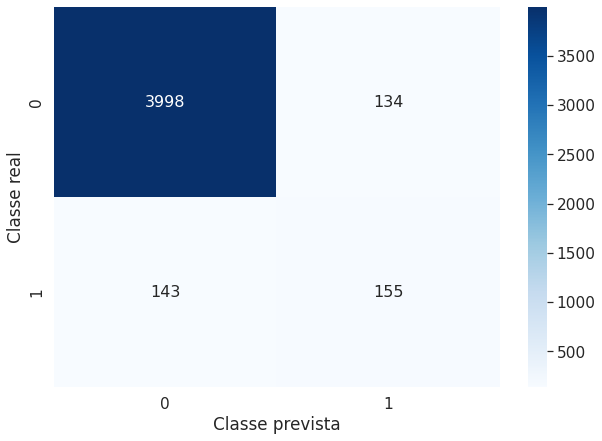

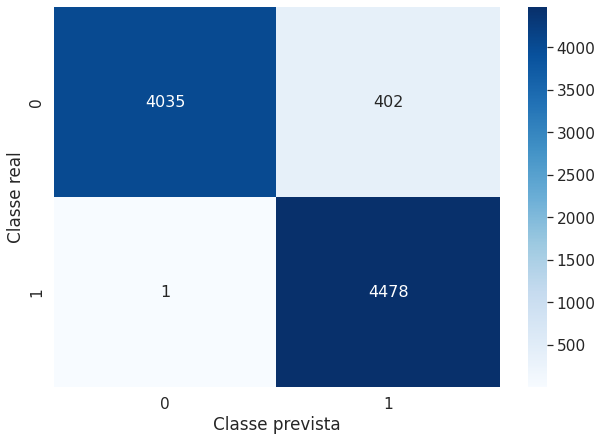

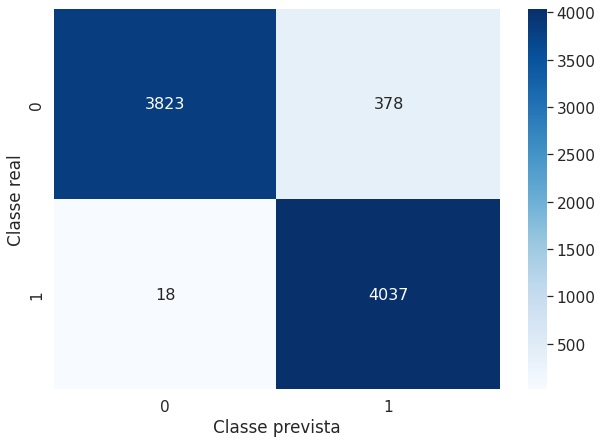

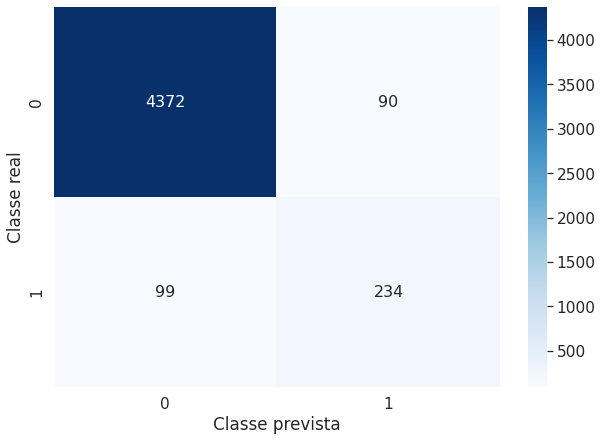

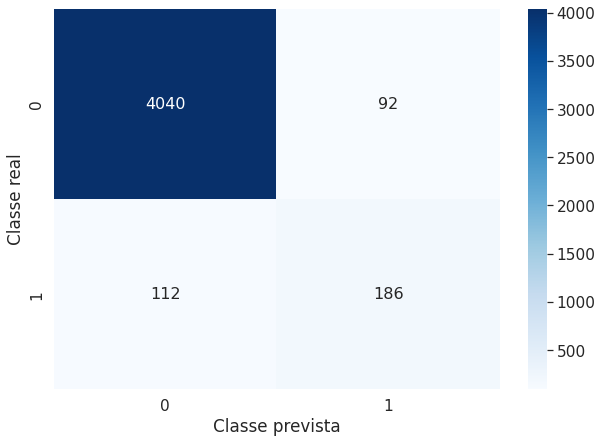

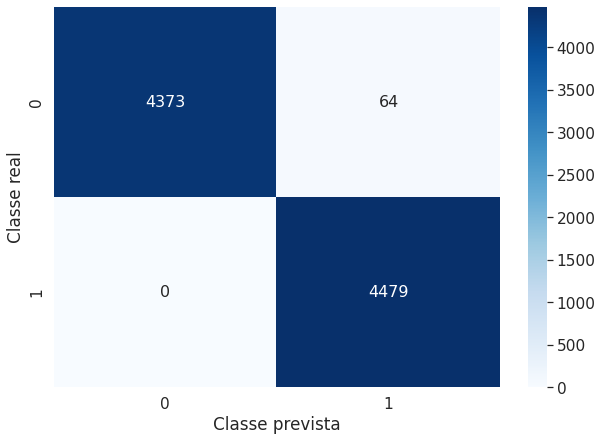

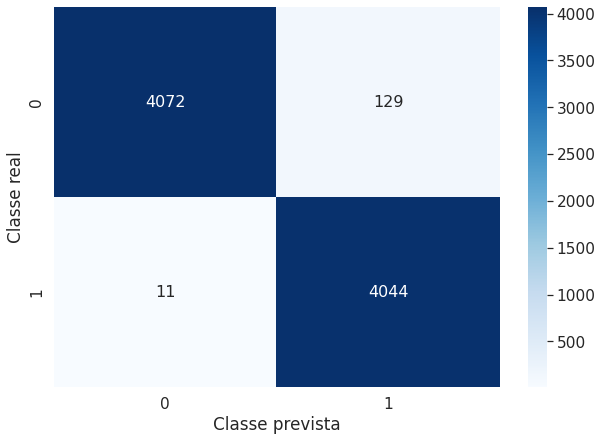

In [26]:
use_augmentation = [False, True]
use_preprocessing = [False, True]
models_used = []
preprocessing_used = []
augmentation_used = []
scores_validation = []
tempos = []
models = ['normal', 'static', 'non_static']

for model in models:

  for aug in use_augmentation:

    for prep in use_preprocessing:

      if aug and prep:
        vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(tokenizer, data_preprocessing_augmentation,  model, prep, aug)
        # vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(data_preprocessing_augmentation,  model, prep, aug)

      elif aug and not prep:
        vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(tokenizer, data_augmentation,  model, prep, aug)
        # vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(data_augmentation,  model, prep, aug)

      elif prep and not aug:
        vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(tokenizer, preprocessed_data,  model, prep, aug)
        # vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(preprocessed_data,  model, prep, aug)

      else:
        vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(tokenizer, normal_data, model, prep, aug)
        # vocab_size, tokenizer, X_train, X_validation, y_train, y_validation = preprocessing_step(normal_data, model, prep, aug)
      
      print('Modelo: {}\nPré-processamento: {}\nBalanceamento: {}\n'.format(model, prep, aug))

      if model == 'normal':
        ini = time.time()
        m, history, validation_score = lstm_normal(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, prep, aug)
        fim = time.time()
        tempo = fim - ini
      elif model == 'static':
        ini = time.time()
        m, history, validation_score = lstm_static(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, prep, aug)
        fim = time.time()
        tempo = fim - ini
      elif model == 'non_static':
        ini = time.time()
        m, history, validation_score = lstm_non_static(vocab_size, tokenizer, X_train, X_validation, y_train, y_validation, prep, aug)
        fim = time.time()
        tempo = fim - ini
      else:
        print('Modelo não encontrado')
        break
        
      print('Modelo finalizado!\n')

      models_used.append(model)
      tempos.append(tempo)
      preprocessing_used.append(prep)
      augmentation_used.append(aug)
      scores_validation.append(validation_score)

In [27]:
results = pd.DataFrame()
results['modelo'] = models_used
results['tempo'] = tempos
results['pré_processamento'] = preprocessing_used
results['balanceamento'] = augmentation_used
results['score_validação'] = scores_validation

In [28]:
results.head(20)

,modelo,tempo,pré_processamento,balanceamento,score_validação
0,normal,452.430248,False,False,0.9521
1,normal,452.451530,True,False,0.9499
2,normal,825.689782,False,True,0.9935
3,normal,753.762676,True,True,0.9924
4,static,142.123887,False,False,0.9486
5,static,121.992678,True,False,0.9370
6,static,272.213671,False,True,0.9547
7,static,273.047550,True,True,0.9520
8,non_static,450.413818,False,False,0.9603
9,non_static,391.703955,True,False,0.9532


In [29]:
results.to_csv('tempos_RNN_CPU.csv', index=False)

In [30]:
!zip -r /content/model.zip /content/Model

  adding: content/Model/ (stored 0%)
  adding: content/Model/model_LSTM-static.h5 (deflated 7%)
  adding: content/Model/model_LSTM-non_static.h5 (deflated 15%)
  adding: content/Model/model_LSTM-static_preprocessing_augmentantion.h5 (deflated 7%)
  adding: content/Model/model_LSTM_preprocessing.h5 (deflated 24%)
  adding: content/Model/model_LSTM.h5 (deflated 16%)
  adding: content/Model/model_LSTM-non_static_augmentantion.h5 (deflated 17%)
  adding: content/Model/model_LSTM_preprocessing_augmentantion.h5 (deflated 25%)
  adding: content/Model/model_LSTM-non_static_preprocessing.h5 (deflated 23%)
  adding: content/Model/model_LSTM-static_preprocessing.h5 (deflated 7%)
  adding: content/Model/model_LSTM-non_static_preprocessing_augmentantion.h5 (deflated 24%)
  adding: content/Model/model_LSTM-static_augmentantion.h5 (deflated 7%)
  adding: content/Model/model_LSTM_augmentantion.h5 (deflated 17%)
  adding: content/Model/.ipynb_checkpoints/ (stored 0%)


In [31]:
!zip -r /content/images_rnn_non_static.zip /content/Images

  adding: content/Images/ (stored 0%)
  adding: content/Images/matriz_confusao_LSTM.jpg (deflated 30%)
  adding: content/Images/matriz_confusao_LSTM-non_static_preprocessing.jpg (deflated 32%)
  adding: content/Images/data_unbalanced.png (deflated 18%)
  adding: content/Images/matriz_confusao_LSTM-non_static.jpg (deflated 29%)
  adding: content/Images/matriz_confusao_LSTM_preprocessing.jpg (deflated 29%)
  adding: content/Images/matriz_confusao_LSTM_augmentation.jpg (deflated 31%)
  adding: content/Images/matriz_confusao_LSTM-static_augmentation.jpg (deflated 30%)
  adding: content/Images/matriz_confusao_LSTM-static_preprocessing_augmentation.jpg (deflated 30%)
  adding: content/Images/matriz_confusao_LSTM-non_static_preprocessing_augmentation.jpg (deflated 31%)
  adding: content/Images/matriz_confusao_LSTM_preprocessing_augmentation.jpg (deflated 32%)
  adding: content/Images/matriz_confusao_LSTM-non_static_augmentation.jpg (deflated 31%)
  adding: content/Images/matriz_confusao_LSTM-

In [32]:
!zip -r /content/submission.zip /content/Submission/

  adding: content/Submission/ (stored 0%)
  adding: content/Submission/LSTM-static_augmentation.csv (deflated 72%)
  adding: content/Submission/LSTM_preprocessing_augmentation.csv (deflated 72%)
  adding: content/Submission/LSTM-static_preprocessing.csv (deflated 72%)
  adding: content/Submission/LSTM_preprocessing.csv (deflated 73%)
  adding: content/Submission/LSTM-non_static_preprocessing.csv (deflated 72%)
  adding: content/Submission/LSTM-static.csv (deflated 73%)
  adding: content/Submission/LSTM-non_static_augmentation.csv (deflated 72%)
  adding: content/Submission/LSTM-non_static_preprocessing_augmentation.csv (deflated 72%)
  adding: content/Submission/LSTM.csv (deflated 72%)
  adding: content/Submission/LSTM-non_static.csv (deflated 73%)
  adding: content/Submission/LSTM_augmentation.csv (deflated 73%)
  adding: content/Submission/LSTM-static_preprocessing_augmentation.csv (deflated 72%)
  adding: content/Submission/.ipynb_checkpoints/ (stored 0%)


In [33]:
!zip -r /content/tokenizer.zip /content/Tokenizer

  adding: content/Tokenizer/ (stored 0%)
  adding: content/Tokenizer/tokenizer.pickle (deflated 54%)
  adding: content/Tokenizer/.ipynb_checkpoints/ (stored 0%)


In [ ]:
while True:
  pass

## Referências

https://www.kaggle.com/hamishdickson/cnn-for-sentence-classification-by-yoon-kim

https://github.com/pinkeshbadjatiya/twitter-hatespeech/blob/master/cnn.py

https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py

https://github.com/satya-thirumani/Python/blob/master/Sentiment%20Analysis/AV_practice_problem_Twitter_Sentiment_Analysis.ipynb

https://github.com/yoonkim/CNN_sentence/blob/23e0e1f7355705bb083043fda05c031b15acb38c/conv_net_classes.py#L340

https://github.com/Jverma/cnn-text-classification-keras/blob/master/text_cnn.py

https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb

https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py